In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/Users/zhangkewen/Documents/scripts/voltagecalculate_1125/')
from FFT_get import fftget
from IFFT_get import ifftget
from equivalent import CEL

In [2]:
#xyz->theta,phi,r
def rotation_m(theta,phi):
    return np.array([[np.cos(theta)*np.cos(phi),-np.sin(phi),np.sin(theta)*np.cos(phi)],
                     [np.cos(theta)*np.sin(phi),np.cos(phi),np.sin(theta)*np.sin(phi)],
                     [-np.sin(theta),0,np.cos(theta)]])



In [3]:
e_theta =56.7
e_phi = 45
N=2000
f0=1
[Lce_complex, antennas11_complex_short] = CEL(e_theta, e_phi, N, f0, 1, 0)



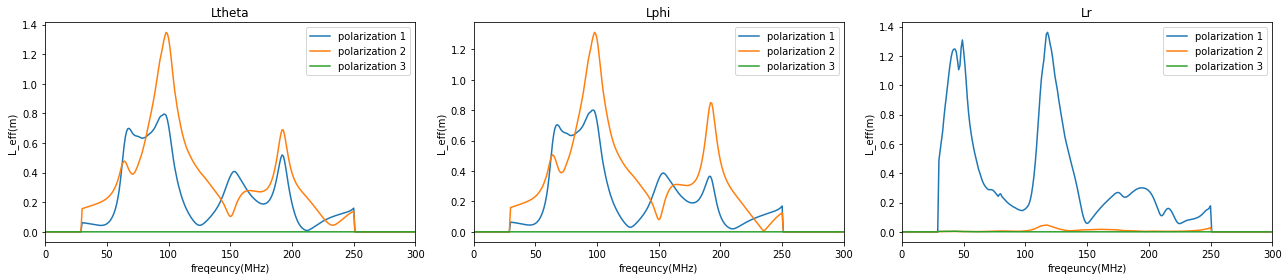

In [17]:
Lce_sphere=np.zeros(np.shape(Lce_complex),dtype='complex')
R_sph2cart=rotation_m(e_theta*np.pi/180,e_phi*np.pi/180)
R_cart2sph=np.linalg.inv(np.matrix(R_sph2cart))
for i in range(2000):
    for j in range(3):
        Lce_sphere[i,:,j]=np.dot(R_cart2sph,Lce_complex[i, :,j])
        
string=['1','2','3']
string_sphere = np.array(['theta', 'phi', 'r'])
plt.figure(figsize=(18, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for j in range(3):
        plt.plot(abs(Lce_sphere[:, j, i]),label='polarization '+string[j])
        plt.title('L'+string_sphere[i])
        plt.xlim(0, 300) 
        plt.legend()
        plt.xlabel('freqeuncy(MHz)')
        plt.ylabel('L_eff(m)')
plt.tight_layout()